# Comparison of two CNN
- Tadhg Ryan 21310408
- Szymon Szulc 21323208

##### Code executes to end with no errors

## Resources:
- 

In [67]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.10.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [68]:
# Import dataset
import kagglehub

# Download latest version
dataset_path = kagglehub.dataset_download("muratkokludataset/rice-image-dataset") + "\\Rice_Image_Dataset"

print("Path to dataset files:", dataset_path)


Path to dataset files: C:\Users\Simon\.cache\kagglehub\datasets\muratkokludataset\rice-image-dataset\versions\1\Rice_Image_Dataset


In [69]:
# Hyperparameters
BATCH_SIZE = 64
IMG_HEIGHT = 250
IMG_WIDTH = 250
K = 3
EPOCHS = 10
LEARNING_RATE = 0.001
MAX_SIZE_DATASET = 1000
NUM_OF_BATCHES = MAX_SIZE_DATASET // BATCH_SIZE
RESIZED_SIZE = 128


In [70]:
# Load data in
import tensorflow as tf

# Create the full dataset (without splitting for validation)
train_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',  # Load labels in grayscale
    shuffle=True,
    validation_split=0.004,
    subset="both",
    seed=42
)

# Get class names for later use
class_names = train_dataset.class_names

train_dataset = train_dataset.take(NUM_OF_BATCHES)
print(f"Taking {NUM_OF_BATCHES} batches")


Found 75000 files belonging to 5 classes.
Using 74700 files for training.
Using 300 files for validation.
Taking 15 batches


Count: Counter({'Arborio': 209, 'Basmati': 195, 'Ipsala': 192, 'Karacadag': 185, 'Jasmine': 179})


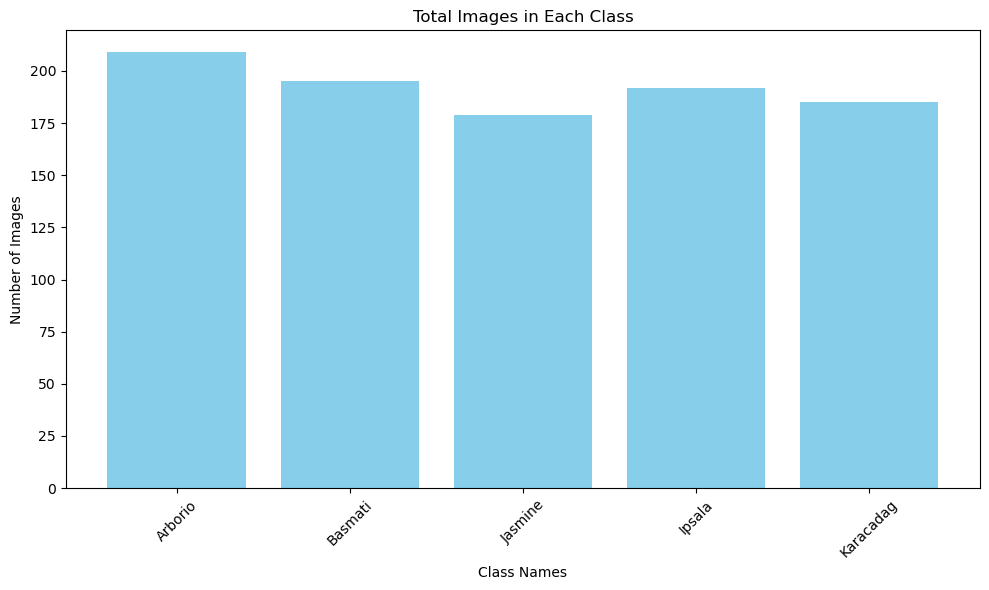

In [71]:
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter()

for images, labels in train_dataset:
    class_counts.update([class_names[label] for label in labels.numpy()])

print(f"Count: {class_counts}")

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.title("Total Images in Each Class")
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [72]:
# Data Augmentation
from tensorflow.keras import layers

# Define the data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"), 		# Flip horizontally
    layers.RandomZoom(-0.2, 0.2),        				# Zoom in on the image
    layers.RandomRotation(0.2),          				# Randomly rotate image
    layers.RandomBrightness(factor=(-0.2, 0.2)),
])
data_scaling = tf.keras.Sequential([
    layers.Resizing(RESIZED_SIZE, RESIZED_SIZE),		# Resize to desired dimensions
])
data_normalisation = tf.keras.Sequential([
    layers.Rescaling(1./255),
])

# Define functions to apply the augmentation
def augment_image(image, label):
    image = data_augmentation(image, training=True)
    return image, label

def scale_image(image, label):
    image = data_scaling(image, training=True)
    return image, label

def normalise_image(image, label):
    image = data_normalisation(image)
    return image, label


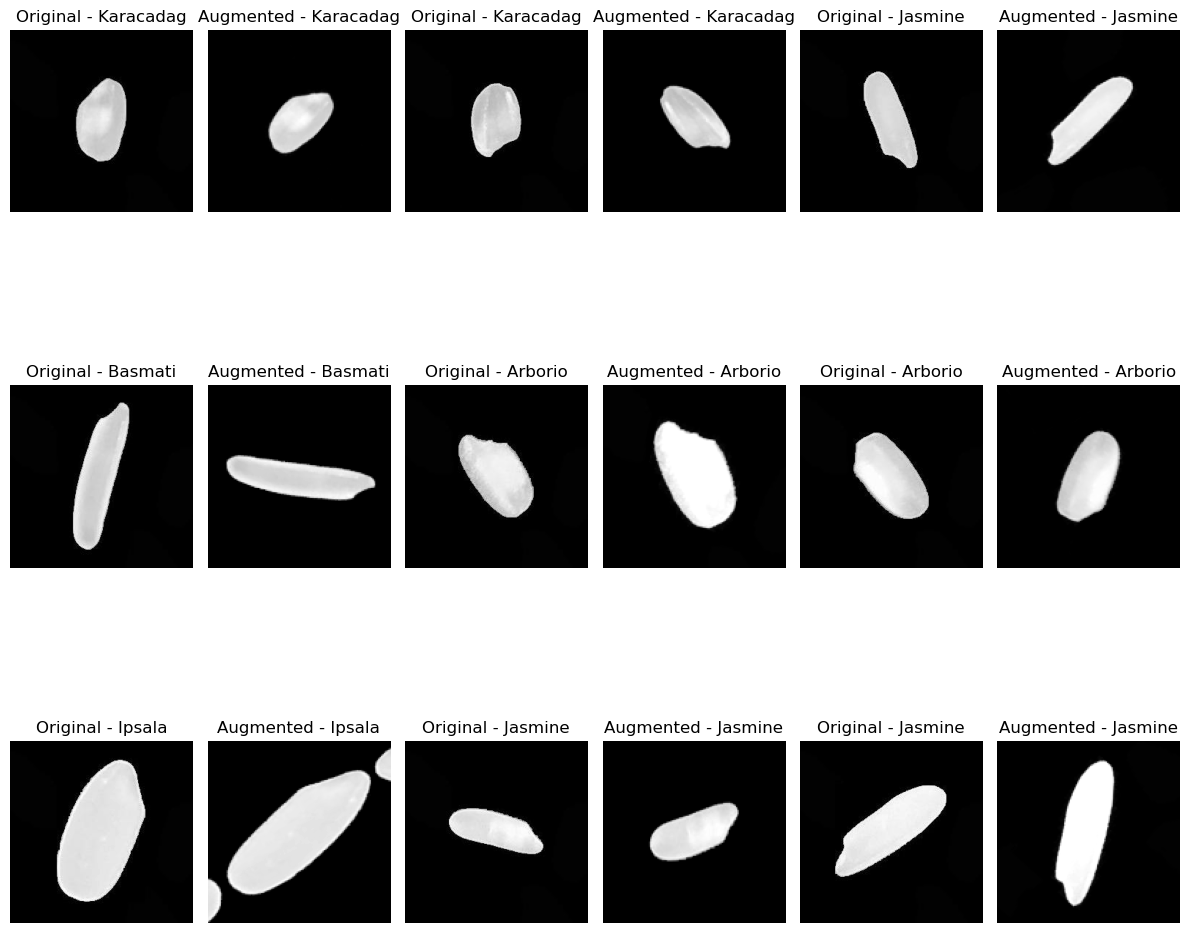

In [73]:
import matplotlib.pyplot as plt
import tensorflow as tf


num_images = 9  # Number of images to display

# Create lists to store images and augmented images
original_images = []
augmented_images = []
labels_list = []

# Iterate through the dataset and collect images and their augmented versions
i = 0
for image_batch, label_batch in train_dataset:
    if i >= num_images:
        break
    original_images.append(image_batch)  # Save original image
    augmented_image = augment_image(image_batch, None)[0]
    augmented_image = scale_image(augmented_image, None)[0]
    augmented_image = normalise_image(augmented_image, None)[0]
    augmented_images.append(augmented_image)  # Save augmented image
    labels_list.append(label_batch)
    i += BATCH_SIZE

# Concatenate the batches into single arrays
original_images_array = tf.concat(original_images, axis=0)
augmented_images_array = tf.concat(augmented_images, axis=0)
labels_array = tf.concat(labels_list, axis=0)

# Select the first `num_images` images and labels to display
original_images_to_display = original_images_array[:num_images]
augmented_images_to_display = augmented_images_array[:num_images]
labels_to_display = labels_array[:num_images]

# Plot the images in a grid
plt.figure(figsize=(12, 12))

for i in range(num_images):
    # Plot original images
    ax = plt.subplot(3, 6, 2 * i + 1)  # Adjust for both original and augmented
    plt.imshow(original_images_to_display[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Original - {class_names[labels_to_display[i].numpy()]}")  # Show class name
    plt.axis("off")

    # Plot augmented images
    ax = plt.subplot(3, 6, 2 * i + 2)
    plt.imshow(augmented_images_to_display[i].numpy().squeeze(), cmap='gray')
    plt.title(f"Augmented - {class_names[labels_to_display[i].numpy()]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

augmented_train_dataset         = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
scale_augmented_train_dataset   = augmented_train_dataset.map(scale_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset                   = scale_augmented_train_dataset.map(normalise_image, num_parallel_calls=tf.data.AUTOTUNE)

scale_test_dataset              = test_dataset.map(scale_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset                    = scale_test_dataset.map(normalise_image, num_parallel_calls=tf.data.AUTOTUNE)


In [74]:
# Create Model 1
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models

def makeInceptionV3(input_shape=(224, 224, 1), num_classes=5, dropout_rate=0.5):
	model = models.Sequential([])
	model.add(layers.Input(shape=input_shape))
	model.add(layers.Resizing(224, 224))
	model.add(layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)))

	inceptionV3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

	for layer in inceptionV3.layers:
		layer.trainable = False

	model.add(inceptionV3)
 
	# Fully connected layers
	model.add(layers.Flatten())
	model.add(layers.Dense(128, activation='relu'))
	model.add(layers.BatchNormalization())
	model.add(layers.Dropout(dropout_rate))
	model.add(layers.Dense(num_classes, activation='softmax'))

	return model, inceptionV3

makeInceptionV3()[0].summary()


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_23 (Resizing)      (None, 224, 224, 1)       0         
                                                                 
 lambda_19 (Lambda)          (None, 224, 224, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_19 (Flatten)        (None, 51200)             0         
                                                                 
 dense_38 (Dense)            (None, 128)               6553728   
                                                                 
 batch_normalization_771 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                     

In [75]:
# Define ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import tensorflow as tf

def makeResNet50(input_shape=(224, 224, 1), num_classes=5, dropout_rate=0.5):
    base_model = ResNet50(
        include_top=False, weights="imagenet", input_shape=(224, 224, 3)
    )

    model = models.Sequential()
    model.add(layers.Input(input_shape))
    model.add(layers.Resizing(224, 224))
    model.add(layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)))

    for layer in base_model.layers:
        layer.trainable = False

    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation="softmax"))

    return model, base_model

makeResNet50()[0].summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_24 (Resizing)      (None, 224, 224, 1)       0         
                                                                 
 lambda_20 (Lambda)          (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_20 (Flatten)        (None, 100352)            0         
                                                                 
 dense_40 (Dense)            (None, 128)               12845184  
                                                                 
 batch_normalization_772 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                     

In [76]:
# VGG16 define

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19

def makeVGG19(input_shape=(224, 224, 1), num_classes=5, dropout_rate=0.5):
	model = models.Sequential()

	model.add(layers.Input(input_shape))
	model.add(layers.Resizing(224, 224))
	model.add(layers.Lambda(lambda x: tf.repeat(x, 3, axis=-1)))

	vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

	for layer in vgg19.layers:
		layer.trainable = False

	model.add(vgg19)
 
	# Fully connected layers
	model.add(layers.Flatten())
	model.add(layers.Dense(128, activation='relu'))
	model.add(layers.BatchNormalization())
	model.add(layers.Dropout(dropout_rate))
	model.add(layers.Dense(num_classes, activation='softmax'))
 
	return model, vgg19

makeVGG19()[0].summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_25 (Resizing)      (None, 224, 224, 1)       0         
                                                                 
 lambda_21 (Lambda)          (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_21 (Flatten)        (None, 25088)             0         
                                                                 
 dense_42 (Dense)            (None, 128)               3211392   
                                                                 
 batch_normalization_773 (Ba  (None, 128)              512       
 tchNormalization)                                               
                                                     

In [77]:
# Callbacks

class UnfreezeAndReduceLRCallback(tf.keras.callbacks.Callback):
	def __init__(self, base_model, unfreeze_layers=2, reduce_lr_factor=0.5, trigger_epoch=3, layers_unfrozen=0):
		super().__init__()
		self.base_model = base_model
		self.unfreeze_layers = unfreeze_layers
		self.reduce_lr_factor = reduce_lr_factor
		self.trigger_epoch = trigger_epoch
		self.layers_unfrozen = layers_unfrozen

	def on_epoch_begin(self, epoch, logs=None):
		if epoch == self.trigger_epoch-1:
			total_layers = len(self.base_model.layers)
			for layer in self.base_model.layers[-self.unfreeze_layers + self.layers_unfrozen:]:
				layer.trainable = True
			print(f"Unfroze the last {self.unfreeze_layers + self.layers_unfrozen} layers out of {total_layers} layers.")
			self.layers_unfrozen += self.unfreeze_layers

			current_lr = self.model.optimizer.learning_rate.numpy()
			new_lr = current_lr * self.reduce_lr_factor
			self.model.optimizer.learning_rate.assign(new_lr)
			print(f"Reduced learning rate from {current_lr:.6f} to {new_lr:.6f}.")


In [78]:
# Defining k-fold cross validation
from sklearn.model_selection import KFold
import numpy as np

def RunKFold(modelFunction, optimiser_class, loss_function, callbacks):
	# Create a KFold object
	kf = KFold(n_splits=K, shuffle=True)

	indices = np.arange(len(train_dataset))

	best_model = None
	best_val_loss = float('inf')

	# Iterate over K folds
	for fold, (train_index, val_index) in enumerate(kf.split(indices)):
		print(f"==================== Fold: {fold+1} ====================")
		train = train_dataset.skip(train_index[0]).take(1)
		for index in train_index[1:]:
			train = ((train_dataset.skip(index)).take(1)).concatenate(train)
		train.cache().prefetch(tf.data.AUTOTUNE)

		val = train_dataset.skip(val_index[0]).take(1)
		for index in val_index[1:]:
			val = ((train_dataset.skip(index)).take(1)).concatenate(val)
		val.cache().prefetch(tf.data.AUTOTUNE)

  		# Recreate the model to avoid reusing weights
		model, baseModel = modelFunction(input_shape=(RESIZED_SIZE, RESIZED_SIZE, 1), num_classes=len(class_names))

		optimiser = optimiser_class(learning_rate=LEARNING_RATE)

		# Compile the model
		model.compile(optimizer=optimiser, loss=loss_function, metrics=['accuracy'])

		unfreezeAndReduceLRCallback = UnfreezeAndReduceLRCallback(baseModel)
		callbacks.append(unfreezeAndReduceLRCallback)
  
		# Train the model on the training dataset
		history = model.fit(train, epochs=EPOCHS, validation_data=val, callbacks=callbacks)
		val_loss = min(model.history.history['val_loss'])
  
		# Update the best model if this fold is better
		if val_loss < best_val_loss:
			best_val_loss = val_loss
			best_model = model
			model.history_data = history.history

	return best_model



In [79]:
# Run Models with k-fold cross validation
from tensorflow.keras import optimizers, losses, callbacks

train_dataset.cache().prefetch(tf.data.AUTOTUNE)

early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

ModelFunctions = [makeInceptionV3, makeVGG19, makeResNet50]
ModelNames = ["InceptionV3", "VGG19", "ResNet50"]

callbacks = [early_stopping]

bestModels = []
for model in ModelFunctions:
	optimiser = optimizers.Adam
	loss_function = losses.SparseCategoricalCrossentropy(from_logits=False)
	print(f"============================================== {ModelNames[len(bestModels)]} Model ==============================================")
	bestModels.append(RunKFold(model, optimiser, loss_function, callbacks))


============================================== InceptionV3 Model ==============================================
==================== Fold: 1 ====================
Epoch 1/10
10/10 [==============================] - 46s 4s/step - loss: 0.7693 - accuracy: 0.7625 - val_loss: 2.7412 - val_accuracy: 0.7781
Epoch 2/10
10/10 [==============================] - 40s 4s/step - loss: 0.4105 - accuracy: 0.8672 - val_loss: 1.7131 - val_accuracy: 0.7406
Unfroze the last 2 layers out of 311 layers.
Reduced learning rate from 0.001000 to 0.000500.
Epoch 3/10
10/10 [==============================] - 42s 4s/step - loss: 0.2891 - accuracy: 0.9000 - val_loss: 0.6750 - val_accuracy: 0.8625
Epoch 4/10
10/10 [==============================] - 44s 5s/step - loss: 0.3018 - accuracy: 0.9062 - val_loss: 0.7160 - val_accuracy: 0.8625
Epoch 5/10
10/10 [==============================] - 44s 5s/step - loss: 0.3007 - accuracy: 0.9000 - val_loss: 0.6209 - val_accuracy: 0.8531
Epoch 6/10
10/10 [==========================

================ Metrics for InceptionV3 Model ================


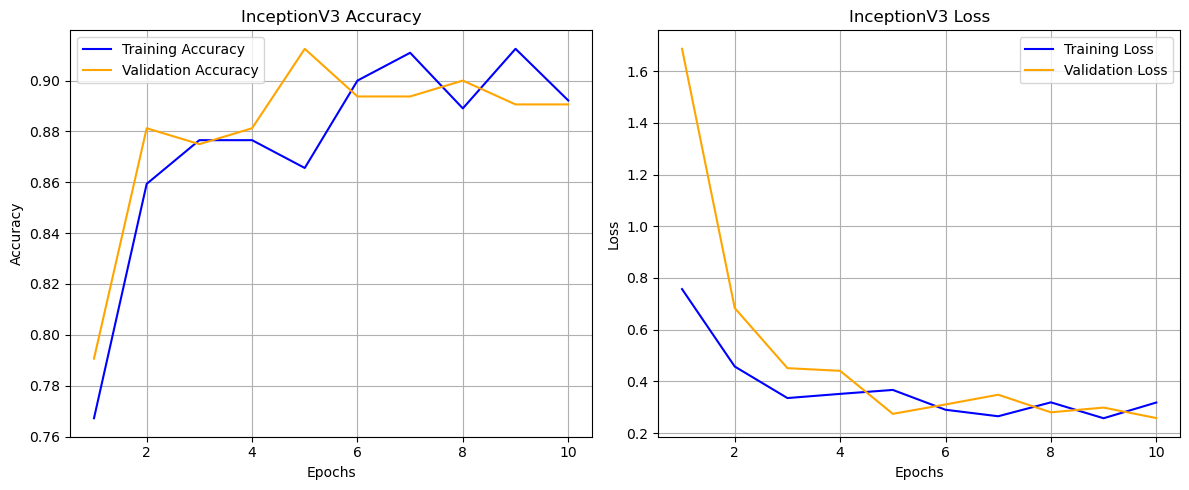

2/2 [==============================] - 3s 269ms/step


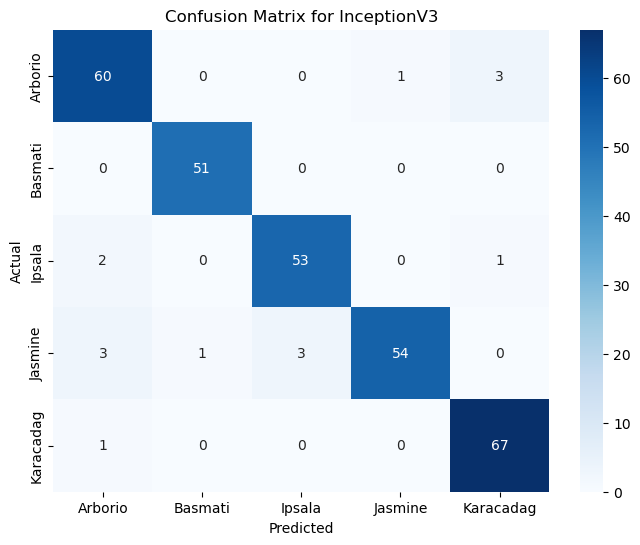

Accuracy: 0.9500


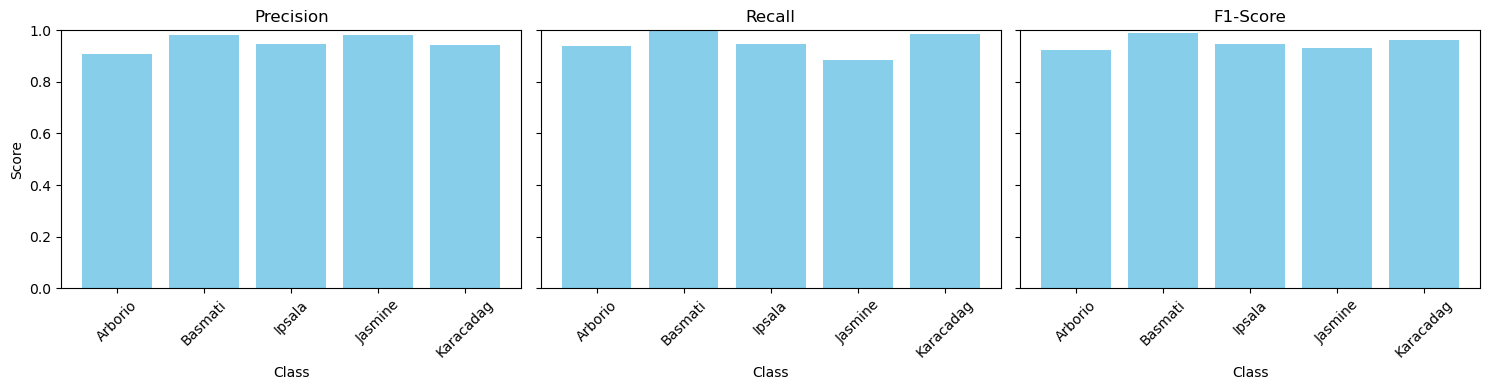


================ Metrics for VGG19 Model ================


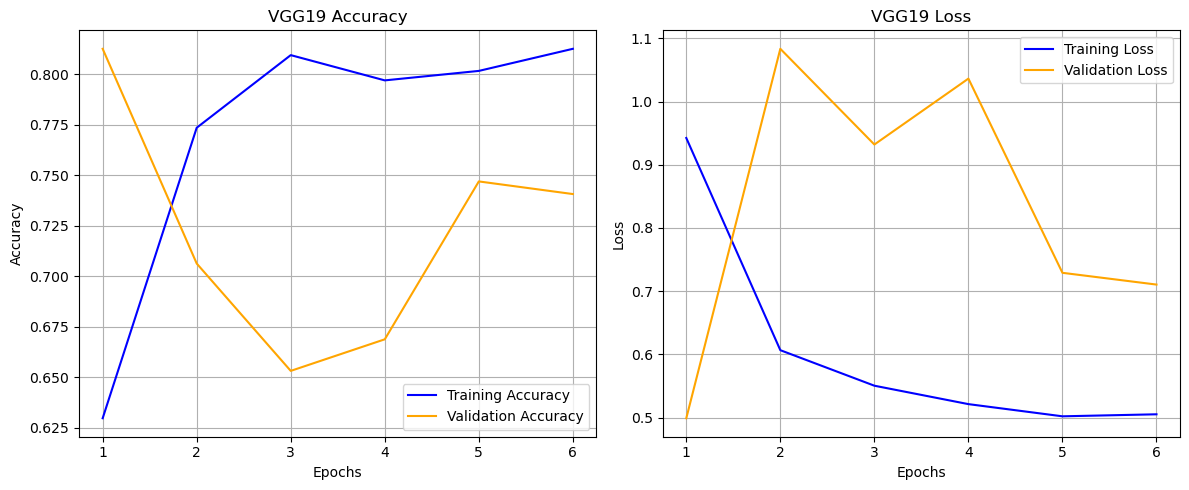

2/2 [==============================] - 1s 243ms/step


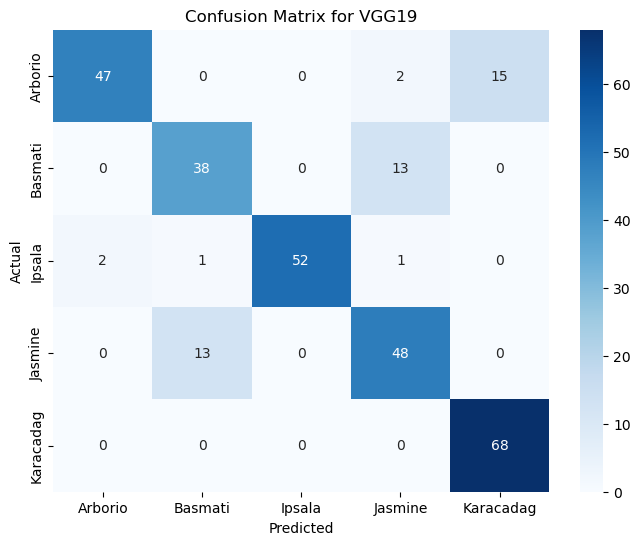

Accuracy: 0.8433


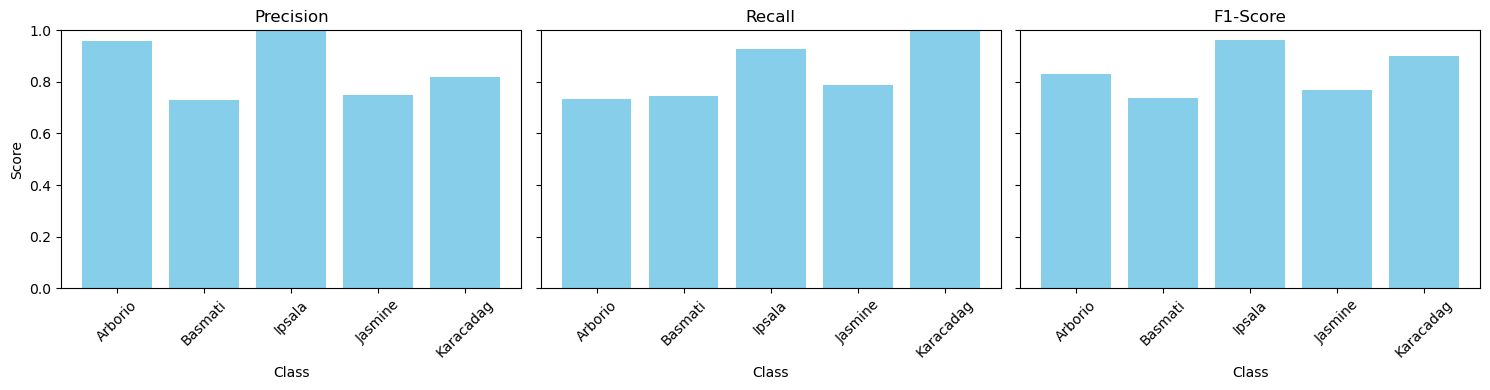


================ Metrics for ResNet50 Model ================


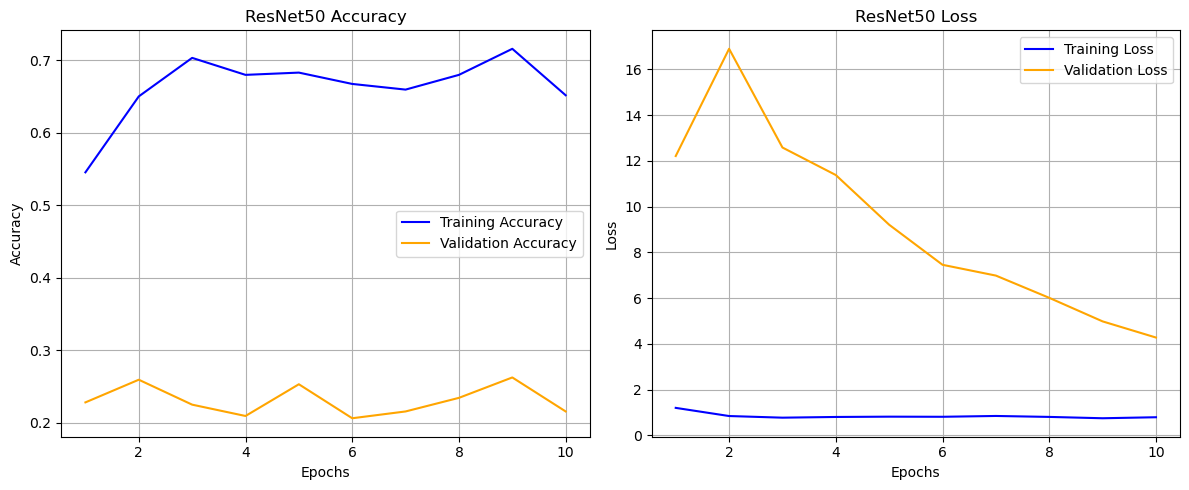

2/2 [==============================] - 2s 171ms/step


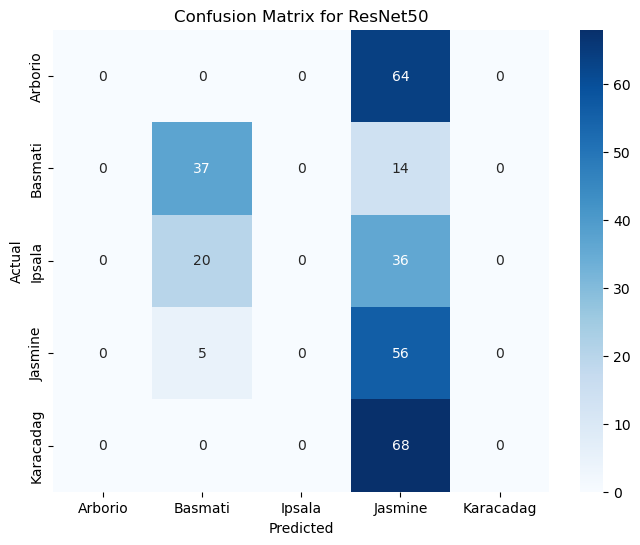

Accuracy: 0.3100


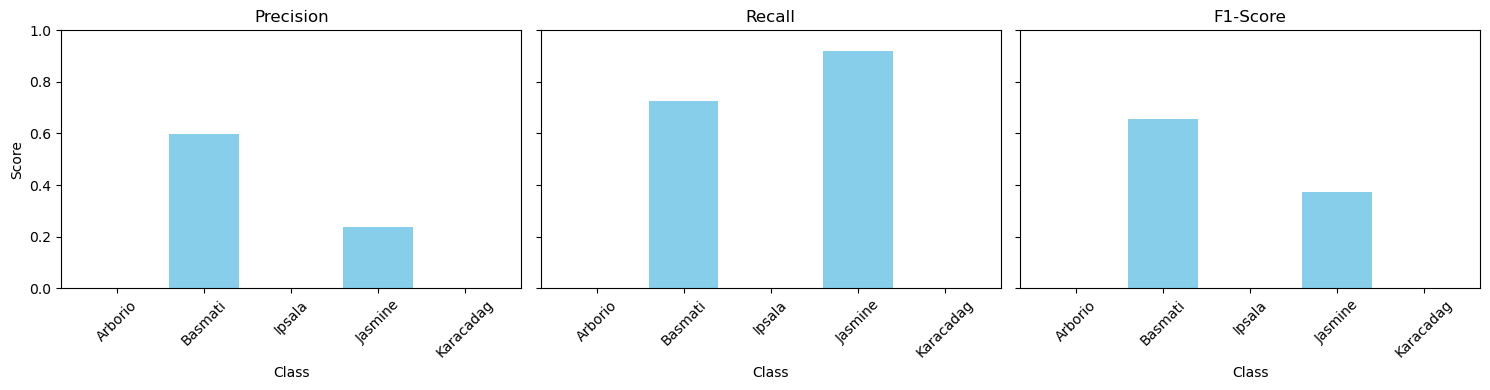

In [80]:
# Compare metrics
# Calculate and display metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
import numpy as np

def plot_training_history(history, model_name):
    """Plots accuracy and loss graphs from the training history."""
    epochs = range(1, len(history['accuracy']) + 1)

    # Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], label='Training Accuracy', color='blue')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], label='Training Loss', color='blue')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', color='orange')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def evaluate_models(models, test_dataset, class_names):
    for i, model in enumerate(models):
        print(f"================ Metrics for {ModelNames[i]} Model ================")

        # Plot training history
        plot_training_history(model.history_data, ModelNames[i])

        # Collect predictions
        y_true = []
        y_pred = []
        for images, labels in test_dataset:
            y_true.extend(labels.numpy())
            predictions = model.predict(images)
            y_pred.extend(np.argmax(predictions, axis=1))

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # Confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.title(f"Confusion Matrix for {ModelNames[i]}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # Precision, recall, F1 score
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, zero_division=0)
        accuracy = accuracy_score(y_true, y_pred)

        print(f"Accuracy: {accuracy:.4f}")

        # Bar charts for metrics
        metrics = [precision, recall, f1]
        metric_names = ["Precision", "Recall", "F1-Score"]

        fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
        for ax, metric, name in zip(axes, metrics, metric_names):
            ax.bar(class_names, metric, color='skyblue')
            ax.set_title(name)
            ax.set_ylim(0, 1)
            ax.set_xlabel("Class")
            ax.tick_params(axis='x', rotation=45)
        axes[0].set_ylabel("Score")

        plt.tight_layout()
        plt.show()

        print("======================================================\n")

# Example call
evaluate_models(bestModels, test_dataset, class_names)
